# Part 1

In [1]:
import pandas as pd
import numpy as np
import re, json, os, requests, scipy.misc
import matplotlib.pyplot as plt
import lxml.html as lh
from bs4 import BeautifulSoup, NavigableString, Tag
from skimage import io, data
from skimage.color import rgb2gray
from skimage.color import rgb2hsv
from scipy import ndimage
from sklearn.decomposition import PCA

# Scraping and Parsing the Data to a Table (Modification of A1) 

In [2]:
full_list_images = []
def get_data(urls, outpath): 
    total_list = {}
   
    for u in urls: 
        page = requests.get(u)
        soup = BeautifulSoup(page.content,'html.parser')
        tb = soup.find_all('table', class_='main')
        title = soup.find('title').get_text('title')[16:]   

        list_names = []
        images = []
        type_art = []
        for link in tb:
            name = link.find('b')
            text = link.find('br')
            
            list_names.append(name.get_text('title'))
            images.append(link.find('img').get('src'))
    
        meta_data = []
        #br tags
        for br in soup.findAll('br'):
            next_s = br.nextSibling
            if not (next_s and isinstance(next_s,NavigableString)):
                continue
            next2_s = next_s.nextSibling
            if next2_s and isinstance(next2_s,Tag) and next2_s.name == 'br':
                text = str(next_s).strip()
                if text:
                    meta_data.append(text)
        
        full_list_images.append(images)
        total_list[title] = list_names,images,meta_data
        if not os.path.exists(outpath):
            os.mkdir(outpath)
    return total_list
cfg = json.load(open('config_a1.json'))   
data = get_data(**cfg)

In [3]:
def process(data): 
    links = []
    titles = []
    misc_data = []
    for i in data.values(): 
        links.append(i[1])
        titles.append(i[0])
        misc_data.append(i[2])
    
    df = pd.DataFrame({'name of painting':titles,
                   'img link':links,
                  'info':misc_data}, 
        
                  index=[list(data.keys())])
    l = []
    for i in df['info']: 
        s_l = []
        for j in range(0,len(i),3): 
            s_l.append(i[j+1:j+3])
        l.append(s_l)
    df['l'] = l
    
    #Index by each painting, and not each era 
    list_one = []
    for i in range(len(df['name of painting'])): #go through each era 
        list_two = []
        for j in range(len(df['name of painting'][i])): #go through each list 

            painting = df['name of painting'][i][j]
            era = list(df.index[i])[0]
            link = df['img link'][i][j]        
            moreinfo = []
            for k in df['l'][i][j]:
                moreinfo.append(k)

            list_two.append([era,painting,link,moreinfo[0]])

        list_one.append(list_two)
    tolist = [j for i in list_one for j in i ]
    big_df = pd.DataFrame(tolist)
    big_df = big_df.rename(columns={0:'era', 1:'painting', 2:'url', 3:'metadata'})

    #painting or drawing
    paintdraw = []
    for i in big_df['metadata']:
        if 'paint' in i or 'canvas' in i:
            paintdraw.append('Painting')
        elif 'paper' in i:
            paintdraw.append('Drawing')
        else: 
            paintdraw.append('N/A')
    big_df['painting or drawing'] = paintdraw
    big_df['metadata'] = big_df['metadata'].str.replace('\n','').str.replace(' ','')
    big_df['metadata'] = big_df['metadata'].str.split(',')

    #separate type and dimensions
    big_df["type"] = big_df["metadata"].str[0]
    big_df['dimensions'] = big_df['metadata'].str[1]
    big_df = big_df.drop(columns=['metadata'])

    return big_df
df = process(data)

In [52]:
def data_test(): 
    cfg = json.load(open('config_a1.json'))   
    data = get_data(**cfg)
    data = process(data)
    return data

In [4]:
#select the first year of the era
df['year'] = df['era'].str.split(',').str[1].str.split('(').str[0].str.strip().str.split('-').str[0]

In [5]:
#convert RGB to HSV to see mean saturation
def mean_saturation(row): 
    rgb_img = io.imread(row)
    hsv_img = rgb2hsv(rgb_img)
    hue_img = hsv_img[:, :, 0]
    saturation_img = hsv_img[:,:, 1]
    value_img = hsv_img[:, :, 2]
    return np.mean(saturation_img, axis=(0,1))
df['mean saturation'] = df['url'].map(lambda x: mean_saturation(x))

In [6]:
def mean_hue(row): 
    rgb_img = io.imread(row)
    hsv_img = rgb2hsv(rgb_img)
    hue_img = hsv_img[:, :, 0]
    return np.mean(hue_img, axis=(0,1))
df['mean hue'] = df['url'].map(lambda x: mean_hue(x))

In [7]:
def mean_brightness(row): 
    rgb_img = io.imread(row)
    return np.mean(rgb_img, axis=(0,1))
df['mean brightness'] = df['url'].map(lambda x: mean_brightness(x))

In [8]:
def edge_score(img):  
    f = io.imread(img)
    #for edge score 
    edges = ndimage.sobel(f)
    return len(edges)
df['edge score'] = df['url'].map(lambda x: edge_score(x))

In [9]:
def grayscale(row): 
    if row == 0: 
        return 'Gray'
    else: 
        return "Color"
df['gray or color'] = df['mean saturation'].map(lambda x: grayscale(x))

In [ ]:
def variance(row): 
    f = io.imread(row)
    return np.var(f)
df['variance'] = df['url'].map(lambda x: variance(x))

In [10]:
len(df)

557

We want to select images that have a pixel count/ resolution greater than 14000. This would still be a majority of the images.

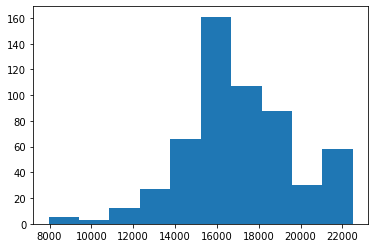

In [11]:
#Select images with a high resolution
def resolution(row): 
    f = io.imread(row)
    return f.shape[0]*f.shape[1]
df['resolution'] = df['url'].map(lambda x: resolution(x))

plt.hist(df['resolution']) 
df = df[df['resolution'] >= 14000]

In [12]:
len(df)/557 #percentage of paintings we will work with

0.895870736086176

In [ ]:
#convert cm to mm TBD 
'''cm = df[df['dimensions'].str.contains("cm")]
for i in range(len(df['dimensions'])): 
    display(df['dimensions'][i])
    if 'cm' in df['dimensions'][i]: 
        try:
            a = int(str(df['dimensions'][i].split('x')[0])+'00')
            b = int(str(df['dimensions'][i].split('x')[1]).replace(u'\xa0', u' ').split(' ')[0]+'00')
            df['dimensions'][i] = (a,b)
        except:
            a = np.NaN'''

The catalogue raisonneé contains images of paintings and drawings, stored as color and grayscale images. Quantitatively, we can automatically distinguish between these two classes of images on the basis of the following features: 

* Grayscale/Color (calculated by the mean saturation of the HSV images) 

* Resolution (calculated by image.shape[0] * image.shape[2]) 

* Dimensions (in mm after normalizing units) 

Images are stored at a variety of resolutions. A threshold/cutoff of a minimum 14000 pixel resolution seems necessary to participate in this analysis. Imagery becomes too indistinct/low-information content to be of use in assessing visual style below this cutoff (which is subject to change dependent on further domain knowledge). Given these decisions, 89.5% of Mondrian's published catalogue raisonné should reasonably be included in your analysis of his stylistic development.

# Image Statistic Plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8940b04fd0>]],
      dtype=object)

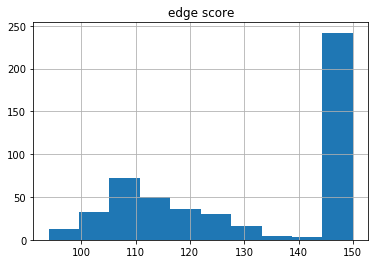

In [13]:
df[['edge score']].hist('edge score')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89409c2a90>]],
      dtype=object)

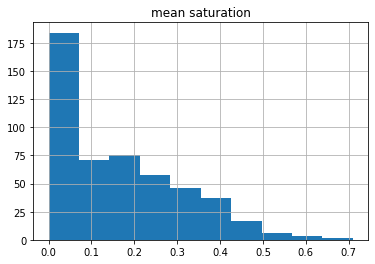

In [14]:
df[['mean saturation']].hist('mean saturation')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f89409c2780>]],
      dtype=object)

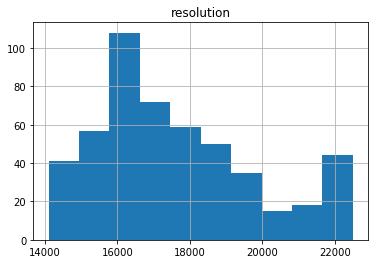

In [16]:
df[['resolution']].hist('resolution')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f893c7ef710>]],
      dtype=object)

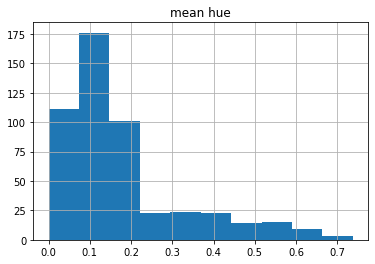

In [17]:
df[['mean hue']].hist('mean hue')

In [18]:
df['year']=df['year'].dropna().astype(int)

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


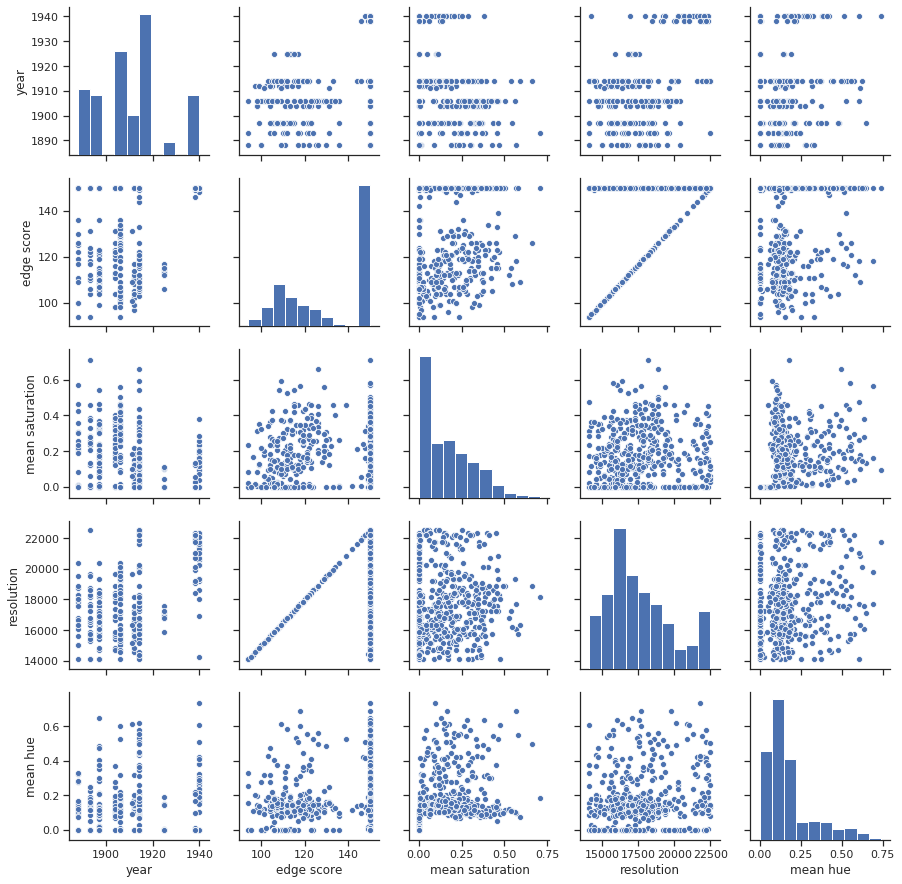

In [19]:
#edge score vs year
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(df[['year','edge score','mean saturation','resolution','mean hue']])

In [53]:
#pca (TBD - clustering) 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


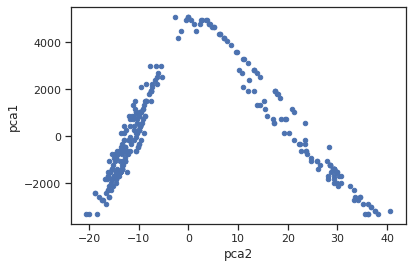

In [33]:
pca = PCA(n_components=2)
df = df.dropna()
pca_df = df[['year','edge score','mean saturation','resolution','mean hue']]
pcs = pca.fit_transform(pca_df)

principalDf = pd.DataFrame(data = pcs,columns = ['pca1', 'pca2'])
principalDf.plot.scatter(1,0)

# Complexity Score ~ Jason Bailey

Complexity score, as calculated by Alexander Koch, is simply the three averaged together: 

* **color_score**: number of RGB values in an image (taking the resolution for now, but **doublecheck this**
* **variance_score**: average of the per-row variance of the grayscale values of all pixels in an image
* **edge_score**: number of edges in an image

In [48]:
df['complexity score'] = (df['variance'] + df['edge score'] + df['resolution'])/3

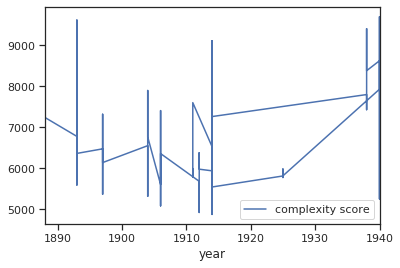

In [51]:
df[['complexity score','year']].plot('year','complexity score')

As we can see above, the complexity score increases as the year increases, though this plot can be refined with even more feature extraction, and fine tuning parameters for PCA.